In [43]:

import pandas as pd
import numpy as np
from collections import Counter
%matplotlib notebook
from sklearn.decomposition import PCA, KernelPCA
import matplotlib
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


ts_data = pd.read_csv('/home/jons51/Downloads/data_akbilgic1.csv')
ts_data = ts_data[ts_data['EM'] != 0] #remove instances of EM with missing values
Y_median = np.median(ts_data['EM'])
ts_data['EM'] = np.where(ts_data['EM'] < Y_median, 0, 1)
ts_data.head(4)

,date,ISE_TL,ISE_US,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM
0,5-Jan-09,0.035754,0.038376,-0.004679,0.002193,0.003894,0.000000,0.031190,0.012698,1
1,6-Jan-09,0.025426,0.031813,0.007787,0.008455,0.012866,0.004162,0.018920,0.011341,1
2,7-Jan-09,-0.028862,-0.026353,-0.030469,-0.017833,-0.028735,0.017293,-0.035899,-0.017073,0
3,8-Jan-09,-0.062208,-0.084716,0.003391,-0.011726,-0.000466,-0.040061,0.028283,-0.005561,0


In [41]:
ts_data.size


5360

Above, I imported the Istanbull Stock Exchange dataset, found at https://archive.ics.uci.edu/ml/datasets/ISTANBUL+STOCK+EXCHANGE

I downloaded the dataset, converted it to a csv file (originally, it was an excel file.) and imported it.
One interesting thing about this dataset, because it is a multivariate time series, is that prediction can be done within each day, by regressing all variables for a given day agains one other, or it can be treated as a time series problem, with predictions occurring over windows over time. 

For this problem, I will treat **EM** as the dependent variable, and all the other variables within each day as predictor variables. Then, each date will be a separate training example. Having experimented with this data set, it is enormously hard to produce a good regression estimate. The data set is too noisy. To make this more tractable, the problem will be changed so that the goal is to predict whether **EM** is above or below it's median value, .00107. To do that, I have converted all **EM** values above 0the median to value = 1, and all below 0the median to value = 0.


    

In [42]:
Y_data = ts_data.iloc[:,9]
X_data = ts_data.iloc[:, 1:9]



test_size = .3
seed = 10
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=test_size, random_state = seed)

In [5]:
X_train.head(2)



,ISE_TL,ISE_US,SP,DAX,FTSE,NIKKEI,BOVESPA,EU
80,-0.012368,-0.021244,-0.002744,-0.018632,-0.017088,-0.027013,0.000022,-0.016192
476,0.012248,0.019146,0.021387,0.026285,0.020447,0.005120,0.023948,0.022417


Above, I split the data into training and testing sets, with 30% of the data randomly assigned to the test set, and 70% to training. as some minor EDA, each variable will be shown as a density plot. 

In [111]:

Counter(Y_train) #count of instances for each class

Counter({0: 182, 1: 193})

<IPython.core.display.Javascript object>


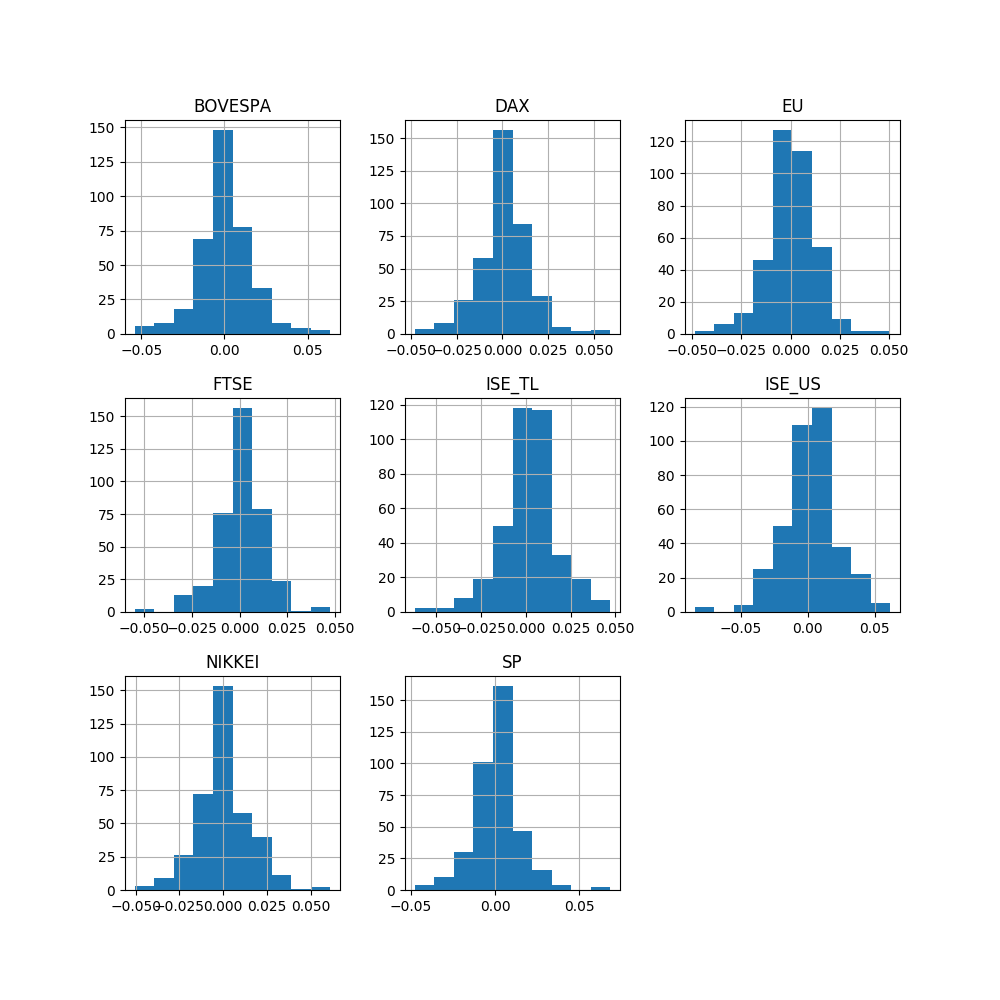

In [5]:
X_train.hist(figsize=(10,10))
plt.show()

These all seem to be approximately symmetric in terms of values, and both skew and kurtosis seem reasonable.

 ## Model Selection
    
For this report, I have chosen four models. Two of them are variants of neural network models. One is an ensemble of support vector machines, each fit to different portions of the data, and one is a random forest model.

One interesting thing about this data set, is that it is likely non-stationary, in that the function that describes the
relationship between the variables likely changes over time. For this reason, ensemble methods are likely to do better than stand alone models. This difference will be explicitly tested with the neural network models.

First, I will use grid search to tune each of the svm hyperparameters, fit, and test the support vector machine models.


In [152]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

#
svm_estimators = 100 #number of estimators to include in model
subset_size = int(round(len(X_train/4)))
svms = []
paramlist = []
predictionlist = []
fitslist = []
scores1 = []  #records R^2 values for fit models.
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10], }
#instantiate models
for _ in range(svm_estimators):
    svms.append(SVC(gamma = 15, class_weight='balanced'))


    #parameter tuning and model fitting

    
for i in range(svm_estimators):
    idx = np.random.choice(len(X_train), size = subset_size, replace=True)
    X_subset = X_train.iloc[idx, :]
    Y_subset = Y_train.iloc[idx]
    #tunedsvm = GridSearchCV(svms[i], parameters)
    fits = svms[i].fit(X_subset, Y_subset)
    scores1.append(fits.score(X_subset, Y_subset))
    fitslist.append(fits.predict(X_subset))
    #now, get prediction on entire test set
    predictionlist.append(fits.predict(X_test))
    

print(scores1)


    

[0.83733333333333337, 0.84533333333333338, 0.7573333333333333, 0.81599999999999995, 0.81333333333333335, 0.78133333333333332, 0.86133333333333328, 0.83466666666666667, 0.84266666666666667, 0.80266666666666664, 0.80533333333333335, 0.81333333333333335, 0.86933333333333329, 0.82666666666666666, 0.79733333333333334, 0.80800000000000005, 0.81866666666666665, 0.84266666666666667, 0.82933333333333337, 0.82399999999999995, 0.83999999999999997, 0.84799999999999998, 0.85599999999999998, 0.86933333333333329, 0.83999999999999997, 0.81333333333333335, 0.80000000000000004, 0.78933333333333333, 0.83733333333333337, 0.82399999999999995, 0.83199999999999996, 0.79733333333333334, 0.81333333333333335, 0.84266666666666667, 0.85866666666666669, 0.83733333333333337, 0.83199999999999996, 0.81066666666666665, 0.81066666666666665, 0.78933333333333333, 0.84533333333333338, 0.81066666666666665, 0.81066666666666665, 0.83466666666666667, 0.77600000000000002, 0.77866666666666662, 0.82133333333333336, 0.86666666666

Now, the trained model's $R^2$ values will be shown. For the record, these are enormously better $R^2$ values than what were obtained with treating **EM** as a continuous variable. There, values where near 0 or even slightly negative for this model. Negative $R^2$ values indicate that it is better to take the mean as a prediction. Overall, this indicates that there is a lot of noise in the dataset, or that the predictors are not very strong in terms of the mutual information they share with **EM**.

### SVM Prediction

This will be a simple aggregate model, in that the predictions will be determined by a simple majority vote. The model predictions were done above as a part of the loop. Below, they will simply be counted, and the accuracy metrics will be shown, with binary score features to evaluate the performance.



In [153]:
fitslistpan = pd.DataFrame(fitslist)
fitslistpan.head(15)

,0,1,2,3,4,5,6,7,8,9,...,365,366,367,368,369,370,371,372,373,374
0,1,0,1,0,0,0,0,1,0,1,...,0,0,1,1,1,1,0,0,1,0
1,0,0,1,0,1,0,1,1,1,1,...,0,0,0,1,1,0,1,1,0,1
2,1,1,1,0,1,0,1,0,1,1,...,1,1,1,1,0,0,1,1,1,1
3,0,0,0,1,0,1,1,0,0,1,...,0,1,0,0,1,0,1,0,0,0
4,0,1,1,0,1,0,1,0,0,0,...,1,1,1,0,1,0,1,1,1,0
5,1,0,1,1,1,0,1,0,1,1,...,1,1,1,0,0,1,0,1,0,1
6,0,1,1,1,1,1,1,1,0,1,...,1,0,1,0,0,0,1,1,1,1
7,0,1,0,0,1,1,1,0,1,1,...,0,1,0,1,0,0,0,0,1,0
8,0,1,0,1,0,0,1,1,0,1,...,0,0,1,1,1,0,1,1,0,1
9,1,0,0,1,0,1,0,0,0,0,...,1,1,0,0,1,0,1,1,1,0


In [155]:
#predictionlist.head(30)
predictionlist_df = pd.DataFrame(np.transpose(predictionlist))
predictionlist_df.head(15)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
5,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
7,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
8,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Model Predictions for 15 of the test samples are shown above. Rows are test data points, and columns are individual model predictions. 

Initially, all outcomes in both the train and test predictions defaulted to all 0's or 1's for each model. In order to prevent this, the gamma parameter needed to be tuned unusually high. It was not until the gamma parameter was set to 15 that there was noticable heterogeneity in predictions from models. This is somewhat worriesome, as it may increase the likelihood of overfitting. As a way of attempting to counterbalance this, a high number of models were used for inference.

In [156]:
aggregate_predictions = predictionlist_df.mean(axis=1)
agg_len = len(aggregate_predictions)
for i in range(agg_len):
    if aggregate_predictions[i] < .5:
        aggregate_predictions[i] = 0
    else:
        aggregate_predictions[i] = 1

In [161]:
from sklearn.metrics import classification_report, roc_auc_score

from IPython.display import display
#display(df)
print(display(classification_report(Y_test, aggregate_predictions)))

'             precision    recall  f1-score   support\n\n          0       0.83      0.76      0.79        86\n          1       0.75      0.83      0.78        75\n\navg / total       0.79      0.79      0.79       161\n'

None


Basic binary scoring metrics are shown above. 

In [162]:
roc_auc_score(Y_test, aggregate_predictions)


0.79124031007751938

 Increasing both the gamma value and the number of model substantially increased the accuracy.
 
 Next, variants of a random forest model will be evaluated on the dataset.

### Random Forest Prediction

There are several different ways to view the data. I will fit models for both the original data, a distance matrix form of the data, as well as adding both the original data and the distance matrix as inputs to see what the differences are in terms of results.

With the original data, all tree splits occur based upon variable values, while with the distance matrix transformation, the distance between covariates are what the tree splits upon.


In [34]:
from sklearn.ensemble import RandomForestClassifier

for i in range(10):
    treenum = 20 + i*10
    rf1 = RandomForestClassifier(random_state=0, n_estimators = treenum)
    rf1.fit(X_train, Y_train)
    rf1_predictions = rf1.predict(X_test)
    print('%s trees' %(treenum),)
    print(classification_report(Y_test, rf1_predictions))



('20 trees',)
             precision    recall  f1-score   support

          0       0.82      0.80      0.81        86
          1       0.78      0.80      0.79        75

avg / total       0.80      0.80      0.80       161

('30 trees',)
             precision    recall  f1-score   support

          0       0.83      0.81      0.82        86
          1       0.79      0.81      0.80        75

avg / total       0.81      0.81      0.81       161

('40 trees',)
             precision    recall  f1-score   support

          0       0.82      0.80      0.81        86
          1       0.78      0.80      0.79        75

avg / total       0.80      0.80      0.80       161

('50 trees',)
             precision    recall  f1-score   support

          0       0.83      0.80      0.82        86
          1       0.78      0.81      0.80        75

avg / total       0.81      0.81      0.81       161

('60 trees',)
             precision    recall  f1-score   support

          0     

In [35]:
roc_auc_score(Y_test, raw_predictions)


0.8303875968992248

From the above, accuracy peaks at about 30-60 trees. Given that there are only seven predictor variables, this is understandable. Next, the distance matrix as input will be tried.

In [36]:
import scipy
X_outer = []
X_outer_test = []

for i in range(len(X_test)):
    
    a = np.subtract.outer(X_test.iloc[i,:], X_test.iloc[i,:])
    X_outer_test.append(a.flatten())
    
X_outerpd_test = pd.DataFrame(X_outer_test)


for i in range(len(X_train)):
    
    b = np.subtract.outer(X_train.iloc[i,:], X_train.iloc[i,:])
    X_outer.append(b.flatten())
    
X_outerpd = pd.DataFrame(X_outer)
X_outerpd.shape
X_outerpd.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.008877,-0.009624,0.006264,0.004720,0.014645,-0.012390,0.003824,-0.008877,0.0,...,0.0,0.016214,-0.003824,0.005053,-0.013448,0.002440,0.000896,0.010821,-0.016214,0.0
1,0.0,-0.006898,-0.009139,-0.014037,-0.008199,0.007128,-0.011700,-0.010169,0.006898,0.0,...,0.0,0.001532,0.010169,0.003271,0.001030,-0.003868,0.001970,0.017297,-0.001532,0.0
2,0.0,0.002305,0.013960,0.011703,0.008319,0.013751,0.015733,0.012846,-0.002305,0.0,...,0.0,-0.002888,-0.012846,-0.010541,0.001115,-0.001143,-0.004527,0.000906,0.002888,0.0
3,0.0,0.003890,0.001524,0.008934,0.002435,0.011197,-0.003566,0.004521,-0.003890,0.0,...,0.0,0.008087,-0.004521,-0.000631,-0.002998,0.004413,-0.002086,0.006675,-0.008087,0.0
4,0.0,-0.003823,-0.000536,-0.005619,-0.005100,-0.003165,-0.009686,-0.003276,0.003823,0.0,...,0.0,0.006410,0.003276,-0.000547,0.002740,-0.002343,-0.001824,0.000111,-0.006410,0.0


In [203]:
for i in range(10):
    treenum = 20 + i*10
    rf2 = RandomForestClassifier(random_state=0, n_estimators = treenum)
    rf2.fit(X_outerpd, Y_train)
    rf2_predictions = rf2.predict(X_outerpd_test)
    print('%s trees' %(treenum),)
    print(display(classification_report(Y_test, rf2_predictions)))


20 trees


'             precision    recall  f1-score   support\n\n          0       0.80      0.81      0.80        86\n          1       0.78      0.76      0.77        75\n\navg / total       0.79      0.79      0.79       161\n'

None
30 trees


'             precision    recall  f1-score   support\n\n          0       0.80      0.78      0.79        86\n          1       0.75      0.77      0.76        75\n\navg / total       0.78      0.78      0.78       161\n'

None
40 trees


'             precision    recall  f1-score   support\n\n          0       0.80      0.77      0.78        86\n          1       0.74      0.77      0.76        75\n\navg / total       0.77      0.77      0.77       161\n'

None
50 trees


'             precision    recall  f1-score   support\n\n          0       0.80      0.73      0.76        86\n          1       0.72      0.79      0.75        75\n\navg / total       0.76      0.76      0.76       161\n'

None
60 trees


'             precision    recall  f1-score   support\n\n          0       0.79      0.71      0.75        86\n          1       0.70      0.79      0.74        75\n\navg / total       0.75      0.75      0.75       161\n'

None
70 trees


'             precision    recall  f1-score   support\n\n          0       0.81      0.70      0.75        86\n          1       0.70      0.81      0.75        75\n\navg / total       0.76      0.75      0.75       161\n'

None
80 trees


'             precision    recall  f1-score   support\n\n          0       0.81      0.73      0.77        86\n          1       0.72      0.80      0.76        75\n\navg / total       0.77      0.76      0.76       161\n'

None
90 trees


'             precision    recall  f1-score   support\n\n          0       0.81      0.73      0.77        86\n          1       0.72      0.80      0.76        75\n\navg / total       0.77      0.76      0.76       161\n'

None
100 trees


'             precision    recall  f1-score   support\n\n          0       0.82      0.72      0.77        86\n          1       0.72      0.81      0.76        75\n\navg / total       0.77      0.76      0.76       161\n'

None
110 trees


'             precision    recall  f1-score   support\n\n          0       0.80      0.73      0.76        86\n          1       0.72      0.79      0.75        75\n\navg / total       0.76      0.76      0.76       161\n'

None


The random forest using the distance matrix all scored worse overall. There are other variations that could have been performed, such as applying a kernel distance measure.



### Neural Networks

The final model type to be used for trying to predict **EM** being above or below it's mean is a neural network. Because there is unlikely to be proximity based correlation, like there would be for images or time series data, a densely connected model will be used. Several variations will be tried, and, like the support vector machine models, a random subspace aggregate model will be used as well. Like decision trees and support vector machines, neural networks are typically low bias/high variance models in terms of statistical error. This makes them good candidates for aggregate modeling techniques. Additionally, since there are only seven predictor variables, and a dense net is being used, no single model will take incredibly long to process, making aggregate methods more pragmatic to use in this case versus situations where larger models are needed. 

The base model class is shown below. Keras models can be instantiated and treated like a class, so it is relatively easy to create many different variants of models. If more portability, or additional, custom objects are desired to be stored for each model, a class can be built around a keras model instantiation.

In [6]:
# keras.models import 
from keras.models import load_model, Model
from keras.layers import Input, Dense, Activation
from keras.regularizers import l2, l1
from keras.optimizers import SGD, Adam
from sklearn import preprocessing

def Keras_model1():
    Input1 = Input(shape=(8,))
    x = Dense(4, activation = 'relu', kernel_regularizer=l2(.001))(Input1)
    x = Dense(4, activation = 'relu', kernel_regularizer=l2(.001))(x)
    x = Dense(4, activation = 'relu', kernel_regularizer=l2(.001))(x)
    out = Dense(1, activation = 'sigmoid', kernel_regularizer=l2(.001))(x)
    model = Model(inputs= Input1, outputs=out)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model



/home/jons51/anaconda/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


First, a single model of the above will be instantiated, trained, and tested, in order to see how it performs.


Validation Loss after final iteration:  0.5025975922620074


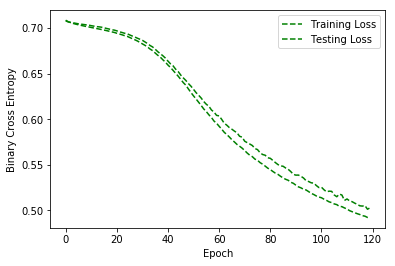

In [7]:
%matplotlib inline

baseline_mod = Keras_model1()
base_fit = baseline_mod.fit(X_train, Y_train, epochs = 120, verbose = 0, validation_data=(X_test, Y_test))

plt.plot(base_fit.history['loss'], 'g--')
plt.plot(base_fit.history['val_loss'], 'g--')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Testing Loss'], loc='upper right')
print "Validation Loss after final iteration: ", base_fit.history['val_loss'][-1]
plt.show()

While there were many models not tested, RELU activation units with .001 L2 regularization seemed to work well. Wider intermediate layers tended to overfit much easier, having much higher validation loss even with higher L2 regularization.

Next, an ensemble of neural networks will be built. Like with the SVM models, the average vote among all models will be used as the final prediction. These will also use random subsets of the data to fit.

Since, with aggregate models, there is less risk of overfitting, an additional layer will be added to the model.


In [8]:
nn_estimators = 15
subset_size = int(round(len(X_train)/4))
nn_predictionlist = []
def Keras_model2():
    Input1 = Input(shape=(8,))
    x = Dense(4, activation = 'relu', kernel_regularizer=l2(.002))(Input1)
    x = Dense(4, activation = 'relu', kernel_regularizer=l2(.002))(x)
    x = Dense(4, activation = 'relu', kernel_regularizer=l2(.002))(x)
    x = Dense(4, activation = 'relu', kernel_regularizer=l2(.002))(x)
    out = Dense(1, activation = 'sigmoid', kernel_regularizer=l2(.002))(x)
    model = Model(inputs= Input1, outputs=out)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def Keras_model3():
    Input1 = Input(shape=(8,))
    x = Dense(4, activation = 'sigmoid', kernel_regularizer=l2(.002))(Input1)
    x = Dense(4, activation = 'sigmoid', kernel_regularizer=l2(.002))(x)
    
    out = Dense(1, activation = 'sigmoid', kernel_regularizer=l2(.002))(x)
    model = Model(inputs= Input1, outputs=out)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model  #sigmoid activation units produce poor performance very easily with increased layers, 
                  #so depth was reduced.


for i in range(nn_estimators):
    idx = np.random.choice(len(X_train), size = subset_size, replace=True)
    X_subset = X_train.iloc[idx, :]
    Y_subset = Y_train.iloc[idx]
    model2 = Keras_model2()
    model3= Keras_model3()
    model2.fit(X_train, Y_train, epochs = 120, verbose = 0, validation_data=(X_subset, Y_subset))
    model3.fit(X_train, Y_train, epochs = 70, verbose = 0, validation_data=(X_subset, Y_subset))
    
    nn_predictionlist.append(model2.predict(X_test))
                                            
    nn_predictionlist.append(model3.predict(X_test))
    


In [29]:
#predictionlist_nn_df = pd.DataFrame(nn_predictionlist)
dim_test = np.array(nn_predictionlist)
#np.shape(dim_test)  #(30, 161, 1)
predictions = np.reshape(dim_test, (30, 161))
raw_predictions = np.mean(predictions, axis = 0)
np.shape(raw_predictions)
agg_len1 = len(Y_test)
#np.shape(raw_predictions)
for i in range(agg_len1):
    if raw_predictions[i] < .5:
        raw_predictions[i] = 0
    else:
        raw_predictions[i] = 1
        


(161,)

Having built the aggregate model for neural networks, the accuracy will be shown.



In [31]:
from sklearn.metrics import classification_report, roc_auc_score


classification_report(Y_test, raw_predictions)



u'             precision    recall  f1-score   support\n\n          0       0.89      0.77      0.82        86\n          1       0.77      0.89      0.83        75\n\navg / total       0.84      0.83      0.83       161\n'

The precision is much higher for this model than it was for the other models. The accuracy was not as high in comparison to the random forest or aggregate support vector machine models.

In [32]:
roc_auc_score(Y_test, raw_predictions)


0.8303875968992248

Overall, the auc score was very slightly higher for the random forest, although neural networks and random forests were both very close in comparison. Using the roc_auc_score as the comparative metric, Random forests, followed by the aggregate neural networks, followed by the aggregate support vector machine model did the best in terms of performance on this dataset. 